# Logistic regression

In [16]:
import numpy as np
from math import sqrt, log
from matrixTool import inverse
from matplotlib import pyplot as plt
import pandas as pd

In [31]:
# 輸入參數
N = 50
mx1 = 1
my1 = 1
mx2 = 10
my2 = 10
vx1 = 2
vy1 = 2
vx2 = 2
vy2 = 2

In [32]:
# 利用HW3產生高斯分佈的數據
def gaussian_data_generator(m, s):
    while(True):
        U = np.random.uniform(-1, 1)
        V = np.random.uniform(-1, 1)
        S = U**2 + V**2   # 規定S要小於1
        if S < 1:
            break
        
    Z = U * sqrt((-2) * log(S) / S)
    p = m + sqrt(s) * Z
    return p

In [33]:
# 依照給定的x、y軸mean&variance，製作guassian sample data points: D1、D2
def sample_point(N, mx, vx, my, vy):
    D = []
    for i in range(N):
        x = gaussian_data_generator(mx, vx)
        y = gaussian_data_generator(my, vy)
        D.append([x, y])
    return np.array(D)

In [34]:
D1 = sample_point(N, mx1, vx1, my1, vy1)
D2 = sample_point(N, mx2, vx2, my2, vy2)

In [35]:
# 製作A矩陣
one = np.ones((N*2, 1))
D = np.concatenate((D1, D2))
A = np.hstack((one, D))

# 製作y矩陣(true)
y = []
for i in range(N*2):
    if i < N:   # 前面50個(D1)lable=0
        y.append([0])
    else:
        y.append([1])
y = np.array(y)

# 製作初始權重w
w0 = np.random.rand(3,1)


##### gradient descent

In [36]:
def gradient_descent(A, y, w):
    # gradient
    J = np.array([10])
    for i in range(100000):     
        J = A.T@(y-(1/(1+np.exp(-A@w))))
        if (J**2).sum() < 1e-2:      # 小於1e-2就停止(代表gradient很接近0)
            break
        else:
            w = w + J                 # 更新權重
    return w, i

In [37]:
# 用gradient descent得到最佳w
w, i = gradient_descent(A, y, w0)
print("第{}次收斂".format(i))

第21次收斂


<ipython-input-36-97ea3e271ec4>:5: RuntimeWarning: overflow encountered in exp
  J = A.T@(y-(1/(1+np.exp(-A@w))))


In [38]:
# label:0=紅色 1=藍色
gradient_red = []
gradient_blue = []
TP, FP, FN, TN = 0, 0, 0, 0

# 因為是logistic function，所以假設機率>0.5:1
logistic_probability = 1/(1+np.exp(-A@w)) 
for i, probability in enumerate(logistic_probability):
    true = y[i][0]  # 真值
    
    # perception(感知器)
    if probability < 0.5:
        gradient_red.append(D[i])
        pred = 0
        if true == pred:
            TP += 1
        else:
            FN += 1
    else:
        gradient_blue.append(D[i])
        pred = 1
        if true == pred:
            TN += 1
        else:
            FP += 1
        
gradient_red = np.array(gradient_red)
gradient_blue = np.array(gradient_blue)

In [39]:
print("Gradient descent:")
print("\nw:\n", w)
print("\nConfusion Matrix: ")
confusion_matrix = pd.DataFrame([[TP,FP], [FN, TN]], index=("Is cluster 1","Is cluster 2"),columns=("Predict cluster 1","Predict cluster 2"))
print(confusion_matrix)
print()
print("Sensitivity (Successfully predict cluster 1): {}".format(TP/(TP+FP)))
print("Specificity (Successfully predict cluster 2): {}".format(TN/(FN+TN)))

Gradient descent:

w:
 [[-278.8138664 ]
 [ -12.15111711]
 [  75.75727888]]

Confusion Matrix: 
              Predict cluster 1  Predict cluster 2
Is cluster 1                 50                  0
Is cluster 2                  0                 50

Sensitivity (Successfully predict cluster 1): 1.0
Specificity (Successfully predict cluster 2): 1.0


##### Newton's method

In [40]:
def newton_method(A, y, w):
    # 先找Hessian matrix
    D = np.zeros((2*N, 2*N))
    for i in range(2*N):
        D[i, i] = np.exp(-A[i] @ w) / (1 + np.exp(-A[i] @ w))**2

    H = A.T @ D @ A

    # H為一半正定矩陣，並不保證可逆
    H_inverse = inverse(H)
    
    # gradient
    J = np.array([10])
    for i in range(100000):     
        J = H_inverse@A.T@(y-(1/(1+np.exp(-A@w))))
        if (J**2).sum() < 1e-2:      # 小於1e-2就停止(代表gradient很接近0)
            break
        else:
            w = w + J                # 更新權重
        
    return w, i

In [41]:
# 用newton method得到最佳w
w, i = newton_method(A, y, w0)
print("第{}次收斂".format(i))

第24次收斂


In [42]:
# label:0=紅色 1=藍色
newton_red = []
newton_blue = []
TP = 0
FP = 0
FN = 0
TN = 0

# 因為是logistic function，所以假設機率>0.5:1
logistic_probability = 1/(1+np.exp(-A@w)) 
for i, probability in enumerate(logistic_probability):
    true = y[i][0]  # 真值
    
    if probability < 0.5:
        newton_red.append(D[i])
        pred = 0
        if true == pred:
            TP += 1
        else:
            FN += 1
    else:
        newton_blue.append(D[i])
        pred = 1
        if true == pred:
            TN += 1
        else:
            FP += 1
            
newton_red = np.array(newton_red)
newton_blue = np.array(newton_blue)

In [43]:
print("Newton's method:")
print("\nw:\n", w)
print("\nConfusion Matrix: ")
confusion_matrix = pd.DataFrame([[TP,FP], [FN, TN]], index=("Is cluster 1","Is cluster 2"),columns=("Predict cluster 1","Predict cluster 2"))
print(confusion_matrix)
print()
print("Sensitivity (Successfully predict cluster 1): {}".format(TP/(TP+FP)))
print("Specificity (Successfully predict cluster 2): {}".format(TN/(FN+TN)))

Newton's method:

w:
 [[-48.50765095]
 [  3.43726699]
 [ 11.30321638]]

Confusion Matrix: 
              Predict cluster 1  Predict cluster 2
Is cluster 1                 50                  0
Is cluster 2                  0                 50

Sensitivity (Successfully predict cluster 1): 1.0
Specificity (Successfully predict cluster 2): 1.0


# 畫圖

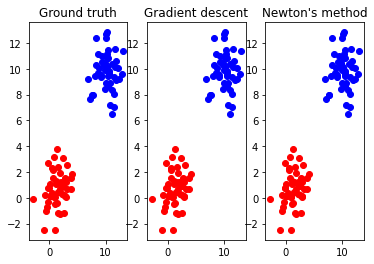

In [44]:
## Ground truth
plt.subplot(131)
plt.title("Ground truth")
plt.plot(D1[:,0], D1[:,1], 'ro')
plt.plot(D2[:,0], D2[:,1], 'bo')

## Gradient descent
plt.subplot(132)
plt.title("Gradient descent")
plt.plot(gradient_red[:,0], gradient_red[:,1], 'ro')
plt.plot(gradient_blue[:,0], gradient_blue[:,1], 'bo')

## Gradient descent
plt.subplot(133)
plt.title("Newton's method")
plt.plot(newton_red[:,0], newton_red[:,1], 'ro')
plt.plot(newton_blue[:,0], newton_blue[:,1], 'bo')
plt.show()